In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = '/Users/hsieh/easySC/result.h5ad'  # the file that will store the analysis results

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.4 pynndescent==0.5.7


In [2]:
adata = sc.read_10x_mtx(
    '/Users/hsieh/easySC/test_10X/',  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True
)
adata.var_names_make_unique()
adata

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 6794880 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
# further filtering
min_genes = 200
min_cells = 3
up_cutoff = 0.75
down_cutoff = 0.25

# Preliminary filtering process
# Preliminary filtering process
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_genes(adata, min_cells=min_cells)

# Generate QC metrics
adata.var["mt"] = adata.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

# Transform the obs to data frame
df_obs= pd.DataFrame(adata.obs)

# Determine the cutoff limits
pct_counts_mt_up_cutoff = df_obs["pct_counts_mt"].quantile(up_cutoff)
total_counts_up_cutoff = df_obs["total_counts"].quantile(up_cutoff)
n_genes_by_count_up_cutoff = df_obs["n_genes_by_counts"].quantile(up_cutoff)

# It is not necessary to filter cells based on the minimal % mitochondrial RNA
# pct_counts_mt_down_cutoff = df_obs["pct_counts_mt"].quantile(down_cutoff)
total_counts_down_cutoff = df_obs["total_counts"].quantile(down_cutoff)
n_genes_by_count_down_cutoff = df_obs["n_genes_by_counts"].quantile(down_cutoff)


# Further filtering process
adata = adata[adata.obs.total_counts < total_counts_up_cutoff, :]
adata = adata[adata.obs.n_genes_by_counts < n_genes_by_count_up_cutoff, :]
adata = adata[adata.obs.pct_counts_mt < pct_counts_mt_up_cutoff, :]

adata = adata[adata.obs.total_counts > total_counts_down_cutoff, :]
adata = adata[adata.obs.n_genes_by_counts > n_genes_by_count_down_cutoff, :]
# adata = adata[adata.obs.pct_counts_mt > pct_counts_mt_down_cutoff, :]

print(f"The pipeline process data with the following criteria:")
print(f"\tCells should contain more than {min_genes} expressed genes.")
print(f"\tGenes should be expressed in more than {min_cells} cells.")
print(
    f"\tCells should contain less than {pct_counts_mt_up_cutoff}% mitochondrial RNA (within {up_cutoff} percentile)."
)
print(
    f"\tCells should contain total counts with the following range:  {total_counts_down_cutoff} - {total_counts_up_cutoff} ({down_cutoff} - {up_cutoff} percentile)."
)
print(
    f"\tCells should contain genes within the following range: {n_genes_by_count_down_cutoff} - {n_genes_by_count_up_cutoff} (represents {down_cutoff} - {up_cutoff} percentile)."
)

print(
            f"After the further filtering process, your data set contains {adata.n_obs} cells and {adata.n_vars} genes."
        )

filtered out 6781987 cells that have less than 200 genes expressed
filtered out 13339 genes that are detected in less than 3 cells
The pipeline process data with the following criteria:
	Cells should contain more than 200 expressed genes.
	Genes should be expressed in more than 3 cells.
	Cells should contain less than 8.010845184326172% mitochondrial RNA (within 0.75 percentile).
	Cells should contain total counts with the following range:  4705.0 - 12124.0 (0.25 - 0.75 percentile).
	Cells should contain genes within the following range: 1539.0 - 3127.0 (represents 0.25 - 0.75 percentile).
After the further filtering process, your data set contains 4670 cells and 23262 genes.


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/hsieh/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


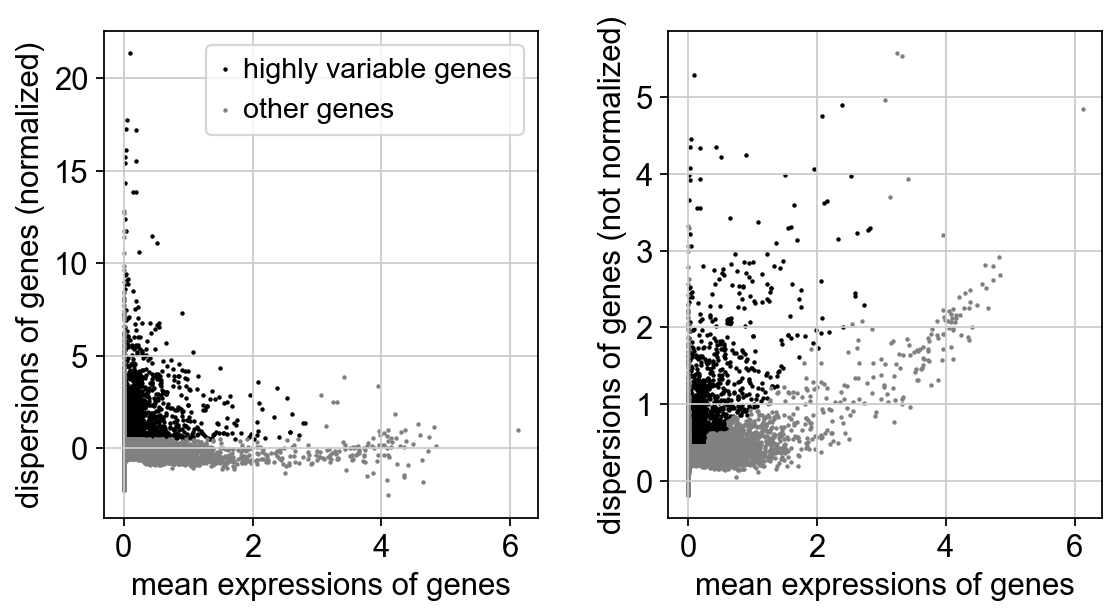

In [4]:
adata_filtered = adata

# Total-count normalize
sc.pp.normalize_total(adata_filtered, target_sum=1e4)

# Logarithmize the data:
sc.pp.log1p(adata_filtered)

# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)

# freeze the data into raw attribute
adata_filtered.raw = adata_filtered

## Save it
sc.pl.highly_variable_genes(adata_filtered,save="_highlyVariableGenes.pdf")


In [5]:
adata_filtered_hvg = adata_filtered[:,adata_filtered.var.highly_variable]
adata_filtered_hvg

df_hvg = pd.DataFrame.sparse.from_spmatrix(adata_filtered_hvg.X,index=adata_filtered_hvg.obs_names,columns=adata_filtered_hvg.var_names)
df_hvg.head()

,HES4,ISG15,TNFRSF18,TNFRSF4,MXRA8,AL645728.1,MIB2,MMP23B,NADK,TNFRSF9,...,AL022162.1,ENOX2,MAP7D3,LINC00892,CD40LG,PDZD4,FLNA,G6PD,GAB3,MPP1
AAACCCAGTTGCCGAC-1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.957683,1.437772,0.0,0.957683
AAACCCATCAGACAAA-1,0.0,0.623972,0.000000,0.623972,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,1.005273,0.000000,0.000000,0.0,0.623972,0.000000,0.0,0.000000
AAACGAACACCGAATT-1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
AAACGAACAGACACCC-1,0.0,0.765016,0.000000,0.000000,0.0,0.0,0.765016,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.765016,0.765016,0.0,0.765016,0.000000,0.0,0.000000
AAACGAACAGAGATTA-1,0.0,0.944139,0.944139,0.000000,0.0,0.0,0.000000,0.944139,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.420985,1.742533,0.0,0.000000


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


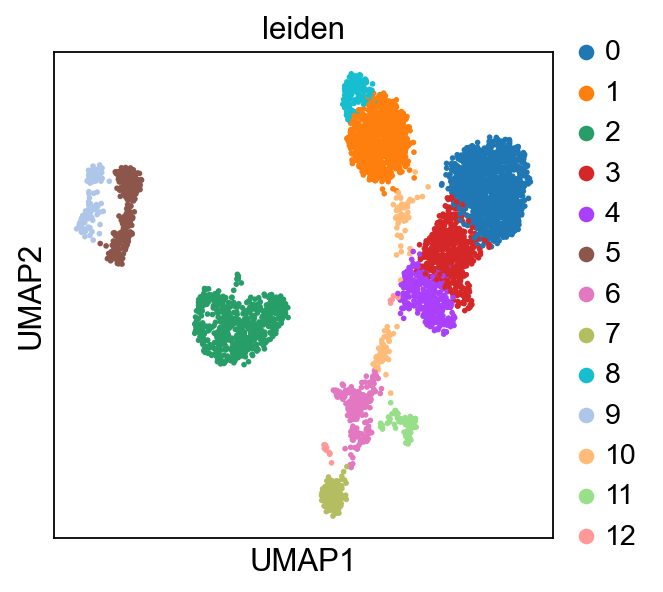

In [6]:
#umap
sc.pp.neighbors(adata_filtered_hvg, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_filtered_hvg)
sc.tl.leiden(adata_filtered_hvg)
sc.pl.umap(adata_filtered_hvg,color=['leiden'],use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


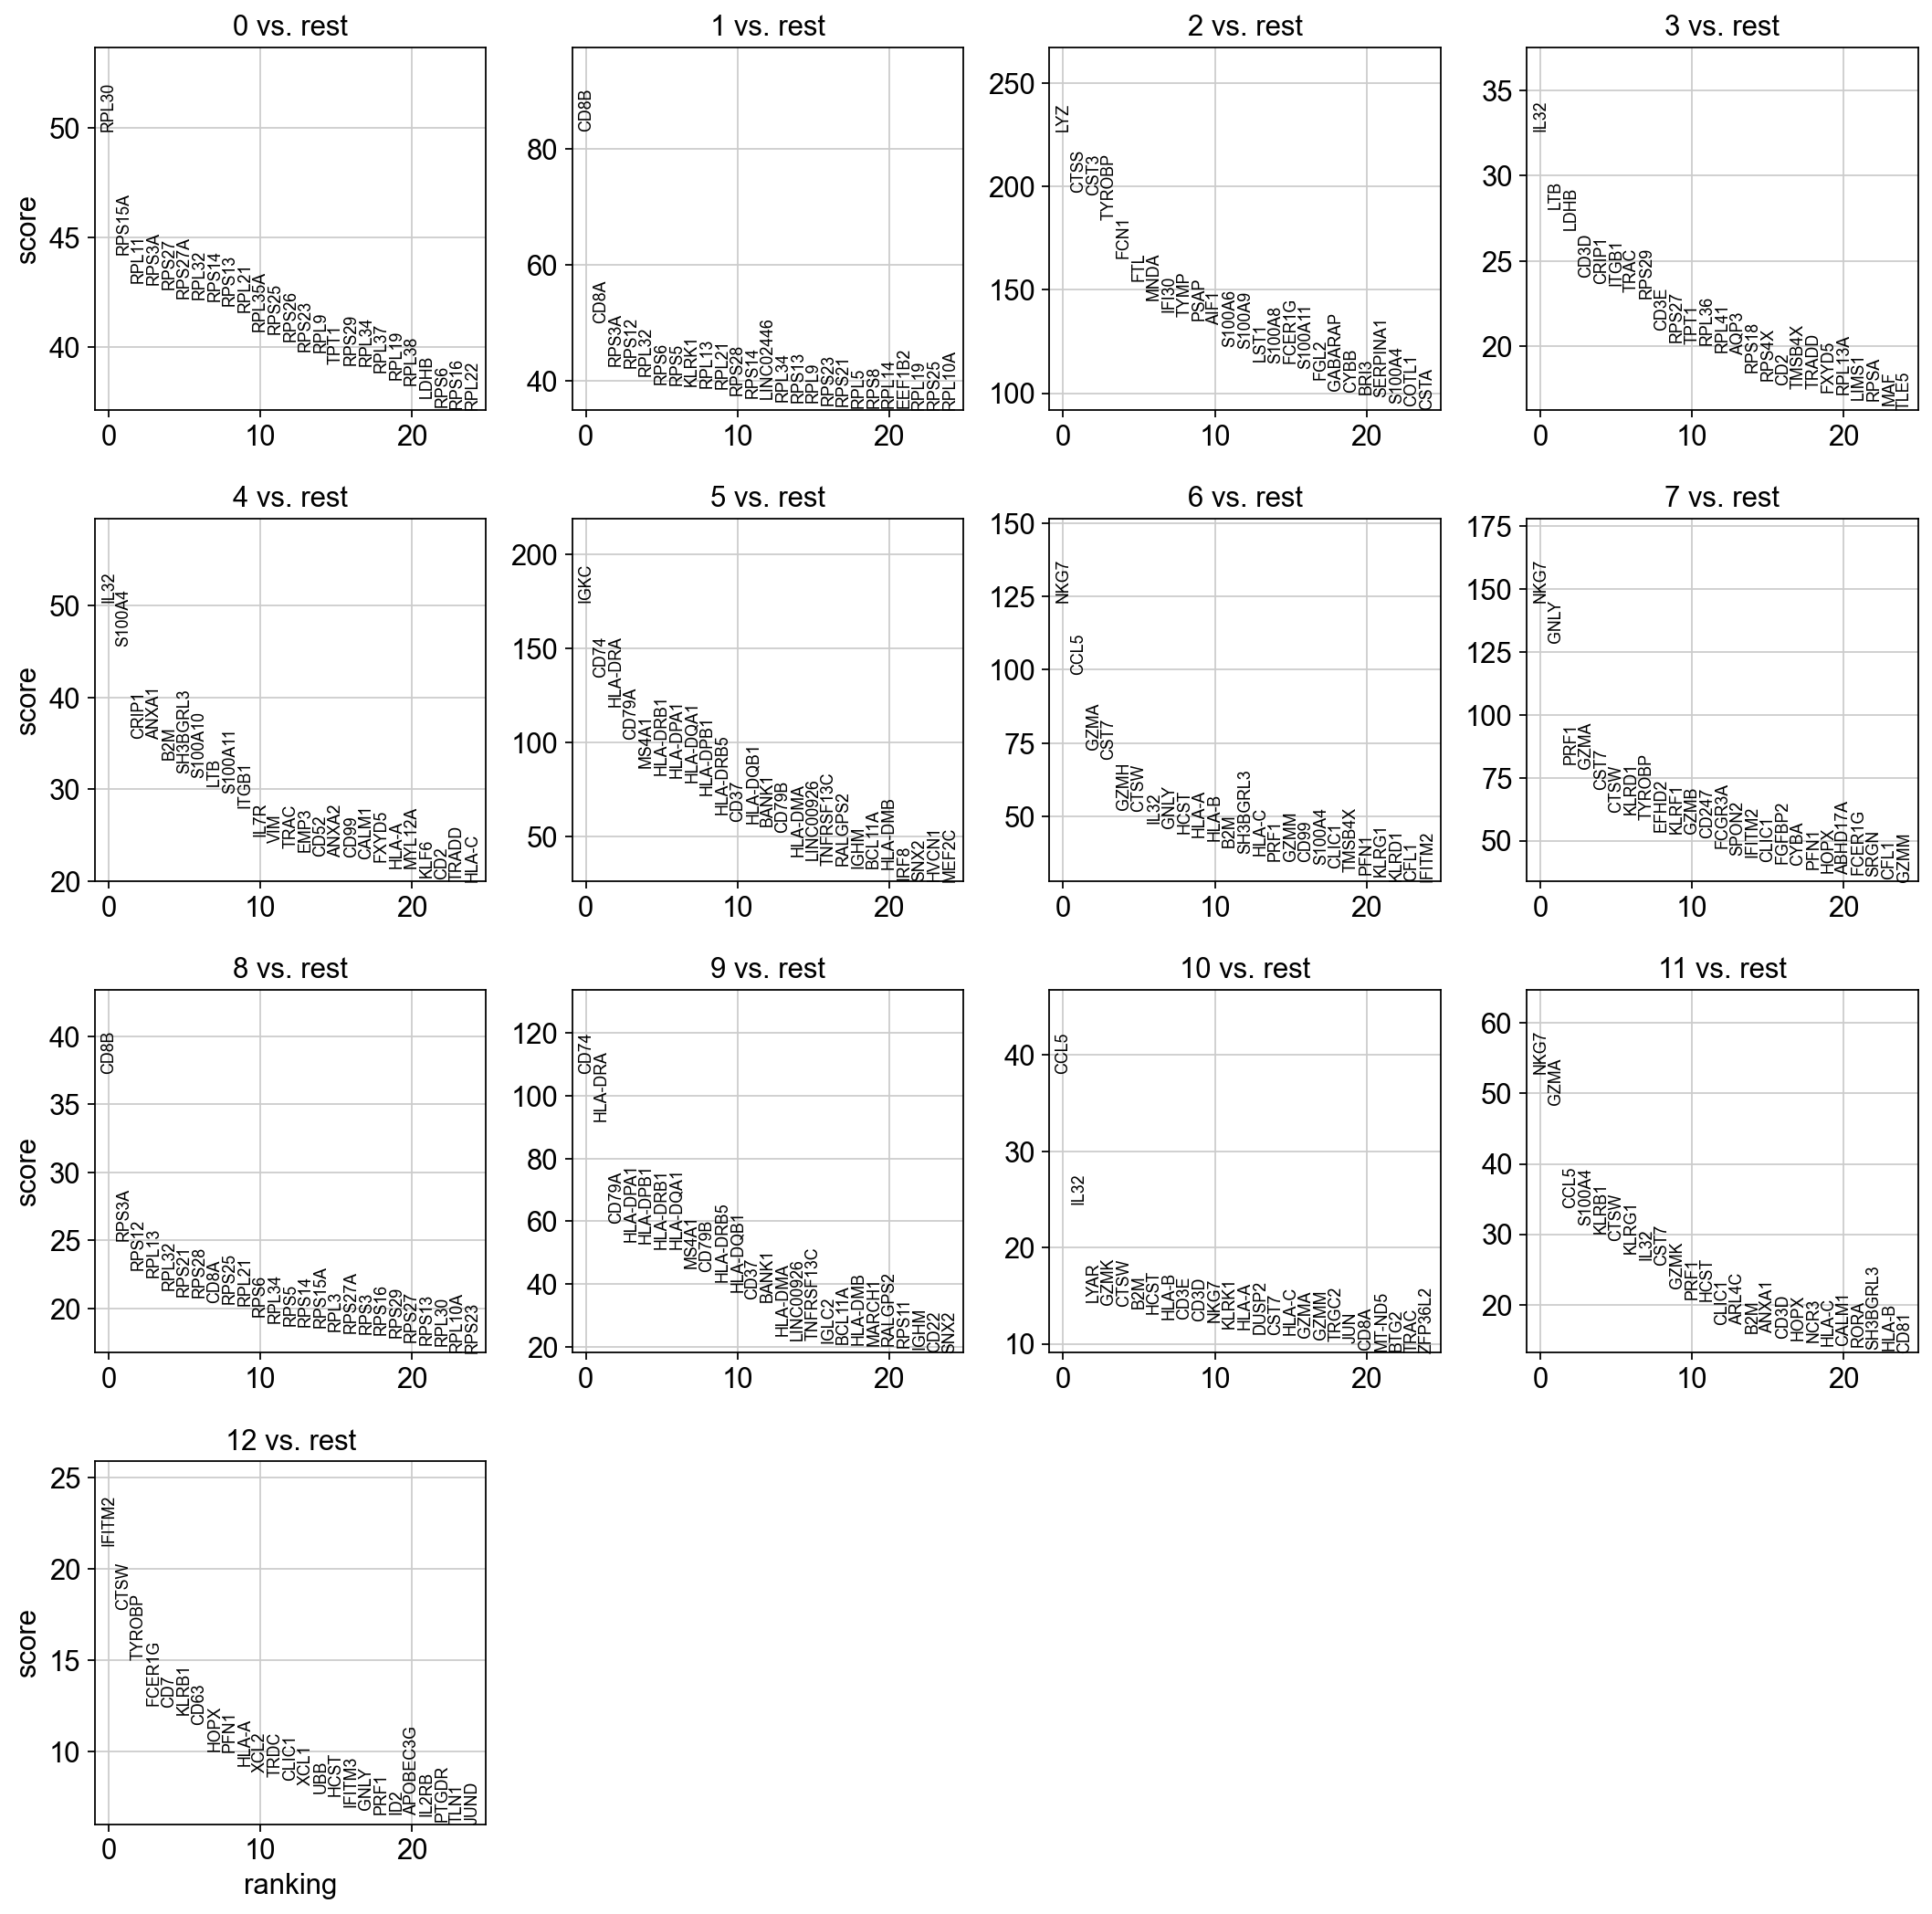

In [16]:
## Marker genes for each cluster

sc.tl.rank_genes_groups(adata_filtered_hvg, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_filtered_hvg, n_genes=25, sharey=False)

In [17]:
pd.DataFrame(adata_filtered_hvg.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,RPL30,CD8B,LYZ,IL32,IL32,IGKC,NKG7,NKG7,CD8B,CD74,CCL5,NKG7,IFITM2
1,RPS15A,CD8A,CTSS,LTB,S100A4,CD74,CCL5,GNLY,RPS3A,HLA-DRA,IL32,GZMA,CTSW
2,RPL11,RPS3A,CST3,LDHB,CRIP1,HLA-DRA,GZMA,PRF1,RPS12,CD79A,LYAR,CCL5,TYROBP
3,RPS3A,RPS12,TYROBP,CD3D,ANXA1,CD79A,CST7,GZMA,RPL13,HLA-DPA1,GZMK,S100A4,FCER1G
4,RPS27,RPL32,FCN1,CRIP1,B2M,MS4A1,GZMH,CST7,RPL32,HLA-DPB1,CTSW,KLRB1,CD7


In [18]:
result = adata_filtered_hvg.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p
0,RPL30,0.0,CD8B,0.000000e+00,LYZ,0.0,IL32,5.399686e-174,IL32,5.025357e-298,...,CD8B,8.298118e-82,CD74,3.949713e-277,CCL5,2.981622e-68,NKG7,1.179355e-74,IFITM2,4.596225e-14
1,RPS15A,0.0,CD8A,9.861434e-299,CTSS,0.0,LTB,1.046989e-130,S100A4,7.261368e-237,...,RPS3A,1.664314e-64,HLA-DRA,2.417479e-206,IL32,2.498714e-54,GZMA,1.192363e-69,CTSW,1.462364e-12
2,RPL11,0.0,RPS3A,0.000000e+00,CST3,0.0,LDHB,1.414200e-126,CRIP1,1.567914e-135,...,RPS12,5.223327e-58,CD79A,6.702009e-102,LYAR,5.852587e-27,CCL5,3.817221e-52,TYROBP,1.429158e-11
3,RPS3A,0.0,RPS12,0.000000e+00,TYROBP,0.0,CD3D,8.290031e-106,ANXA1,2.749129e-147,...,RPL13,4.594696e-58,HLA-DPA1,1.190449e-105,GZMK,2.445368e-26,S100A4,2.503208e-58,FCER1G,3.588312e-10
4,RPS27,0.0,RPL32,1.240426e-306,FCN1,0.0,CRIP1,1.704991e-93,B2M,1.306478e-131,...,RPL32,4.875940e-53,HLA-DPB1,1.235832e-102,CTSW,1.680507e-26,KLRB1,8.679508e-46,CD7,4.816540e-10
